# Density Estimation - Anomaly Detection
<div>It's an algorithm that automaticly find examples that are significantly different from the rest of the data. It finds gaussian curves for every feature so it can understand how the data is distributed, then it multiplies all these gaussian curves on a single variable that estimates how close the example is to the rest of the data</div>

<img src='http://hyperphysics.phy-astr.gsu.edu/hbase/Math/immath/hwidc.gif' width='200' align='mid'>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Gaussian_2d.svg/300px-Gaussian_2d.svg.png' width='200' align='mid'>

<div>An anomalous example will most likely fall on the 'floor' of this graph, indicating that it is very discrepant.
<br>

This algorithm is not like the other supervised learning algoritms, since it doesn't need a lot of positive examples to learn. In fact, it only 'learns' from negative examples. Positive examples are used to test the model.</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

#### Using 50 setosas to build the model and 10 versicolors as anomalies

In [2]:
iris = load_iris()
data = pd.DataFrame(np.c_[iris.data, iris.target], 
                    columns=np.concatenate((iris.feature_names,["species"])))
data = data.loc[:59]
data.tail(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
50,7.0,3.2,4.7,1.4,1.0
51,6.4,3.2,4.5,1.5,1.0
52,6.9,3.1,4.9,1.5,1.0
53,5.5,2.3,4.0,1.3,1.0
54,6.5,2.8,4.6,1.5,1.0
55,5.7,2.8,4.5,1.3,1.0
56,6.3,3.3,4.7,1.6,1.0
57,4.9,2.4,3.3,1.0,1.0
58,6.6,2.9,4.6,1.3,1.0
59,5.2,2.7,3.9,1.4,1.0


#### It helps a lot if features are atleast near a normal distribution. If they aren't, then try to apply transformations such as log(x), x**-1/i, log(x+c), etc. 

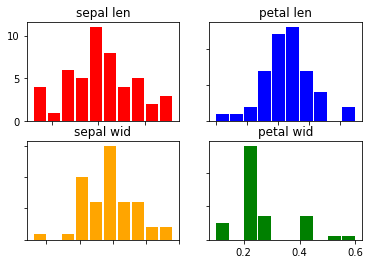

In [3]:
X = data.iloc[:49,[0,1,2,3]]
y = data.iloc[:49,-1]

fig, axes = plt.subplots(2,2)
axes[0,0].hist(np.asarray(X)[:,0], bins=10, rwidth=0.9, color='r')
axes[0,0].set_title('sepal len')

axes[1,0].hist(np.asarray(X)[:,1], bins=10, rwidth=0.9, color='orange')
axes[1,0].set_title('sepal wid')

axes[0,1].hist(np.asarray(X)[:,2], bins=10, rwidth=0.9, color='b')
axes[0,1].set_title('petal len')

axes[1,1].hist(np.asarray(X)[:,3], bins=10, rwidth=0.9, color='g')
axes[1,1].set_title('petal wid')

plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False);
plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False);
plt.setp([a.get_xticklabels() for a in axes[:, 0]], visible=False);
plt.setp([a.get_yticklabels() for a in axes[1, :]], visible=False);

#### Splitting data

In [4]:
X_train, X_test = train_test_split(np.asarray(X), test_size=0.2, random_state=1)

# Appending 10 versicolors to the test data
X_test = np.concatenate((data.iloc[pd.DataFrame(X_test).index, [0,1,2,3]], data.iloc[50:60, [0,1,2,3]]))
y_test = np.concatenate((data.loc[pd.DataFrame(X_test).index, 'species'], data.loc[50:60, 'species']))

print("X_train size (setosas):", len(X_train), "\nX_test size (setosas + 10 versicolors):", len(X_test))

X_train size (setosas): 39 
X_test size (setosas + 10 versicolors): 20


#### Finding the mean of every feature j from training examples

In [5]:
mus = np.mean(X_train, axis=0)
mus

array([5.04615385, 3.47692308, 1.46153846, 0.25641026])

#### Finding the variance of every feature j from training examples

In [6]:
sigmas = np.var(X_train, axis=0)
sigmas

array([0.13017751, 0.15869822, 0.03518738, 0.01322814])

#### After finding the mean and variance of the training examples, calculate p(x) of a new example x as the product of the formula below for every  xj, meanj, variancej 

<img src='https://cdn-images-1.medium.com/max/1600/1*t4zrihvhtlZJZsvcX3jRjg.png' width='300'>

In [7]:
def p(X, mus, sigmas):
    return (1/np.sqrt(sigmas*2*np.pi)) * np.exp(-np.power((X - mus),2) / (2*sigmas) )

def p_example(X, mus, sigmas):
    prob = 1
    for j in range(X.shape[1]):
        prob *= p(X[:,j], mus[j], sigmas[j])
        
    return prob

#### Then set a value for epsilon. Calculate p(xi) for every xi and if p(xi) < epsilon, then flag it as an anomaly.

In [8]:
epsilon = 0.01
p_example(X_test, mus, sigmas) < epsilon

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [9]:
print("Anomalies:\n", X_test[p_example(X_test, mus, sigmas) < epsilon])

Anomalies:
 [[7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.9 1.5]
 [5.5 2.3 4.  1.3]
 [6.5 2.8 4.6 1.5]
 [5.7 2.8 4.5 1.3]
 [6.3 3.3 4.7 1.6]
 [4.9 2.4 3.3 1. ]
 [6.6 2.9 4.6 1.3]
 [5.2 2.7 3.9 1.4]]


#### It predicted correctly all 10 anomalies (versicolors)